In [1]:
# import the usual suspects

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# read in the data, view first 5 rows

df=pd.read_csv('Advertising.csv')

df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


All units in thousands of dollars.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [4]:
df[df.duplicated()]

,TV,radio,newspaper,sales


In [5]:
# the data has zero nulls and not a single observation is duplicated

In [6]:
# summary statistics

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TV,200.0,147.0425,85.854236,0.7,74.375,149.75,218.825,296.4
radio,200.0,23.2640,14.846809,0.0,9.975,22.90,36.525,49.6
newspaper,200.0,30.5540,21.778621,0.3,12.750,25.75,45.100,114.0
sales,200.0,14.0225,5.217457,1.6,10.375,12.90,17.400,27.0


## EDA

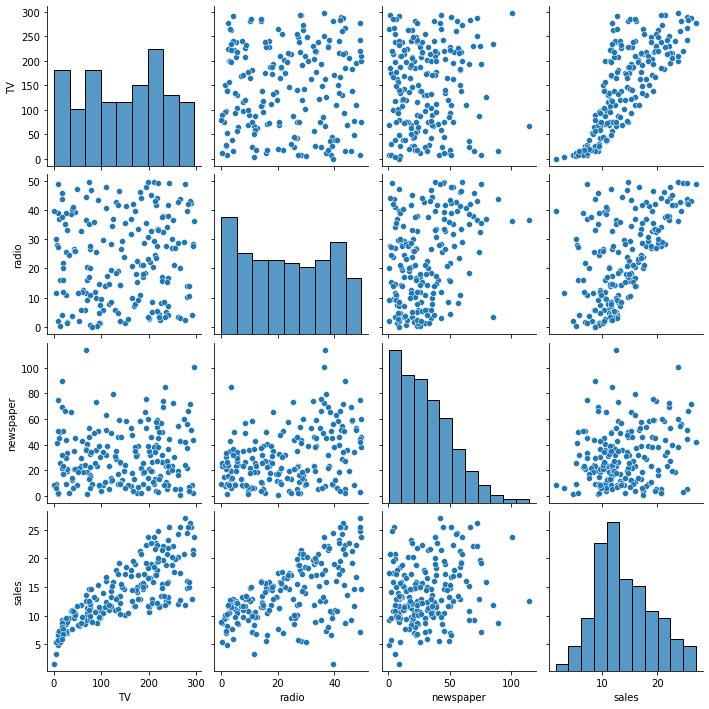

In [7]:
# visualize all the data
# check some of the assumptions (linearity, no multicollinearity)

sns.pairplot(df)

`Independence` among the observations is met as it is assumed that each observation (row) represents a unique campaign (combination of TV, radio and newspaper).

TV and radio appear to have a linear relationship with sales. The same can't be said about the newspaper spend. We should consider dropping the newspaper column but it stays for now. The `linearity assumption` is therefore met (in a hushed tone) but further confirmation will come later.

The `no multicollinearity` assumption is met as no two independent variables appear highly correlated with each other. We'll confirm this with a pairplot and by calculating the Variance Inflation Factors (VIF).

We'll check the rest of the assumptions after the model is built as they rely on the residuals.

<AxesSubplot:>

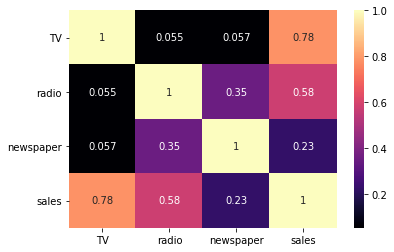

In [8]:
# visualize variable correlation in a heatmap 

sns.heatmap(df.corr(), annot=True, cmap='magma')

Newspaper has a very low correlation with sales (0.23). TV is the most correlated with sales.

In [9]:
# import variance inflation factor

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a subset of the data with the continous independent variables. 
vif_data = df.drop('sales', axis=1)

# Calculate the variance inflation factor for each variable.
vif = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]

# Create a DataFrame with the VIF results for the column names in X.
df_vif = pd.DataFrame(vif, index=vif_data.columns, columns = ['VIF'])

# Display the VIF results.
df_vif

,VIF
TV,2.486772
radio,3.285462
newspaper,3.055245


There is correlation between the independent variables but it is small.

`No muliticollinearity` assumption is therefore met.

## Model building

In [10]:
# import ordinary least squares

from statsmodels.formula.api import ols

In [11]:
# the actual model

ols_formula = 'sales ~ TV + radio + newspaper'

ordinary_ls = ols(formula=ols_formula, data=df)

model = ordinary_ls.fit()

In [12]:
# model results

results=model.summary()

results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Mon, 29 May 2023   Prob (F-statistic):           1.58e-96
Time:                        20:28:17   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
radio          0.1885      0.009     21.893      0.000       0.172       0.206
newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Remeber we were suspicious about newspaper as a feature in our model. The `p-value` of the newspaper coefficient is `0.860` which is greater than the `significance level` of `0.05`. This means that it is not statistically significant at `p = 0.05`.

Furthermore, newspaper has a coefficient of `-0.0010`. Holding both TV and radio constant, a unit increase in the newspaper spend would actually result in a `0.0010` *decrease* in unit sales.

We therefore need to drop it a feature and refit the model. 

In [13]:
# refit model without newspaper

paperless_ols_formula = 'sales ~ TV + radio'
paperless_df = df.drop('newspaper',axis=1)

paperless_ordinary_ls = ols(formula=paperless_ols_formula, data=paperless_df)

paperless_model = paperless_ordinary_ls.fit()

In [14]:
paperless_results = paperless_model.summary()

paperless_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     859.6
Date:                Mon, 29 May 2023   Prob (F-statistic):           4.83e-98
Time:                        20:28:17   Log-Likelihood:                -386.20
No. Observations:                 200   AIC:                             778.4
Df Residuals:                     197   BIC:                             788.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9211      0.294      9.919      0.000       2.340       3.502
TV             0.0458      0.001     32.909      0.000       0.043       0.048
radio          0.1880      0.008     23.382      0.000       0.172       0.204
==============================================================================
Omnibus:                       60.022   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.679
Skew:                          -1.323   Prob(JB):                     5.19e-33
Kurtosis:                       6.292   Cond. No.                         425.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Checking assumptions

Before analyzing the results, let's confirm the rest of our assumptions.

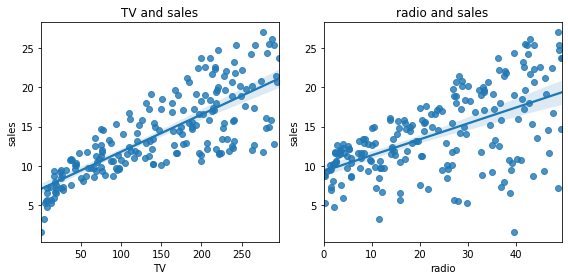

In [15]:
# recheck linearity

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

sns.regplot(x='TV', y='sales', data=paperless_df, ax=axes[0])
axes[0].set_title('TV and sales')

sns.regplot(x='radio', y='sales', data=paperless_df, ax=axes[1])
axes[1].set_title('radio and sales')

plt.tight_layout()

Linearity is met.

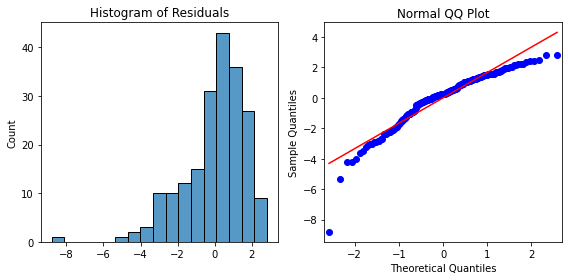

In [16]:
# check normality

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

sns.histplot(paperless_model.resid, ax=axes[0])
axes[0].set_title('Histogram of Residuals')

sm.qqplot(data=paperless_model.resid, ax=axes[1], line='s')
axes[1].set_title('Normal QQ Plot')

plt.tight_layout()

On the histogram, the residuals appear approximately normal.

On the QQ plot, the residuals appear to follow a straight line therefore confirming that the normality assumption is met.

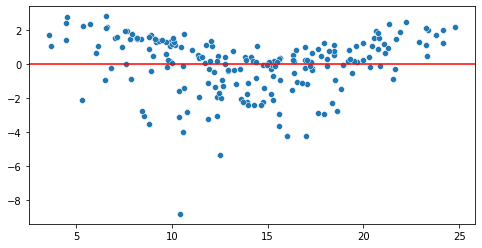

In [17]:
# check homoscedasticity

plt.figure(figsize=(8,4))
sns.scatterplot(x = paperless_model.fittedvalues, y = paperless_model.resid)
plt.axhline(0, c='r')

The data points do not follow a clear pattern meaning homoscedasticity is met.

## Results and Evaluation

In [18]:
paperless_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     859.6
Date:                Mon, 29 May 2023   Prob (F-statistic):           4.83e-98
Time:                        20:28:17   Log-Likelihood:                -386.20
No. Observations:                 200   AIC:                             778.4
Df Residuals:                     197   BIC:                             788.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9211      0.294      9.919      0.000       2.340       3.502
TV             0.0458      0.001     32.909      0.000       0.043       0.048
radio          0.1880      0.008     23.382      0.000       0.172       0.204
==============================================================================
Omnibus:                       60.022   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.679
Skew:                          -1.323   Prob(JB):                     5.19e-33
Kurtosis:                       6.292   Cond. No.                         425.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

An `R-squared` of `0.897` is good. It means that the paperless model explains $89.7\%$ of the variation in sales.

Both independent variables (TV and radio) have a `p-value` of `0.000` with $95\%$ confidence intervals of `[0.043 - 0.048]` and `[0.172 - 0.204]` respectively. They are therefore statistically significant at the significance level of `0.05`.

The model coefficients are:

* $\beta_{0} = 2.9211$
* $\beta_{TV} = 0.0458$
* $\beta_{radio} = 0.1880$

Both TV and radio have positive coefficients further confirming the assumption that they have a positive linear relationship with sales.

$\text{Sales} = \beta_{0} + \beta_{1}*X_{1} + \beta_{2}*X_{2}$

$\text{Sales} = \beta_{0} + \beta_{TV}*X_{TV} + \beta_{radio}*X_{radio}$

$\text{Sales} = 2.9211 + 0.0458*X_{TV} + 0.1880*X_{radio}$

Holding radio constant, a unit increase in TV spend results in a 0.0458 increase in unit sales.

Holding TV constant, a unit increase in radio spend reults in a 0.1880 increase in unit sales.

## Recommendation

Money allocated to newspaper advertisements is better spent elsewhere.